# Optic Classifier Modulation Using Fresnel Diffraction

In order to achieve the project goal, the optical system is modeled as consisting of an input image of a digit from the MNIST dataset, a lens, a mask, and an output screen. The input image is first passed through the lens, which focuses the light and projects the image onto the mask. The mask is designed using optimization algorithms to identify the digit using fresenl diffraction. Once the mask has been optimized, the light passes through it and onto the output screen, where the final image is produced. By simulating the propagation of light through this system and applying optimization techniques to the mask design, we can create a model that accurately recognizes the digit input image.


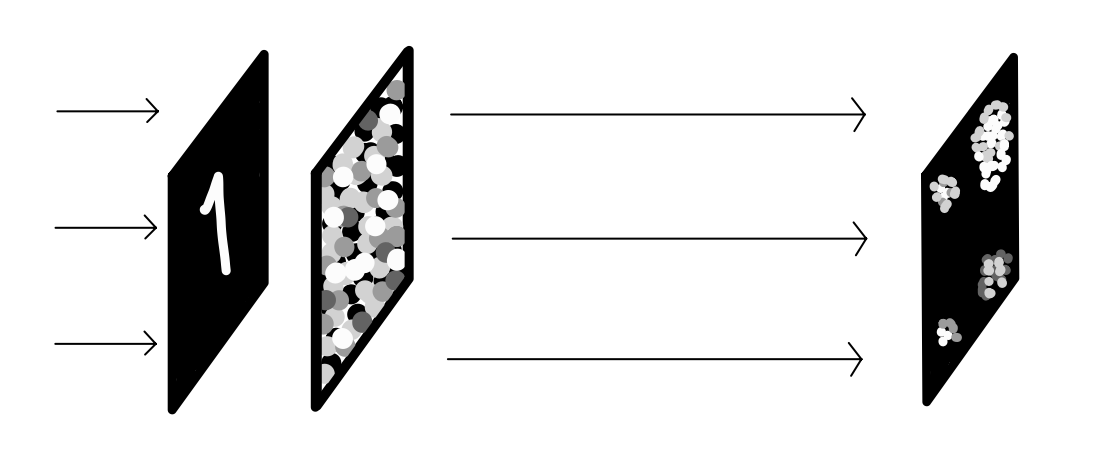

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import fresnel
import pandas as pd
import scipy as sp
import time
import helpers

## Constants

In [2]:
TRAIN_PATH = 'datasets/mnist_train.csv' # Path to dataset
TEST_PATH = 'datasets/mnist_test.csv' # Path to dataset 
LAMBDA = 425e-9 # Wave length
APERTURE = 5e-4 # Size of aperture
D = 0.01 # Propagation distance to the sensor
N = 28 # Size of picture

## Preproccessing 
Preprocessing data is the practice of transforming raw data into a format that can be easily analyzed and understood by optimization models. It involves a variety of techniques such as cleaning, normalization, encoding, and feature scaling, with the aim of improving data quality and reducing noise.

In [3]:
# Read CSV file into numpy array
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)


# Filter out rows where the first column is not in {0,1,2,3}
train_df = train_df[train_df['label'].isin([0,1])]
test_df = test_df[test_df['label'].isin([0,1])]

# Generate lables array 
train_labels = train_df['label'].to_numpy()
test_labels = test_df['label'].to_numpy()

# Generate train and test datasets 
train_df = train_df.iloc[:, -784:]
test_df = test_df.iloc[:, -784:]
train_dataset = train_df.to_numpy()
test_dataset = test_df.to_numpy()

# Save train size of datasets
train_size = train_dataset.shape[0]
test_size = test_dataset.shape[0]



## Fresnel Diffraction
Fresnel diffraction in Fourier optics refers to the mathematical description and analysis of the diffraction patterns created by light passing through an aperture or encountering an obstacle. It utilizes the Fourier transform to decompose the complex wavefront into its component spatial frequencies. By applying Fourier optics principles, one can predict and manipulate the diffraction patterns to achieve desired outcomes in fields such as imaging, signal processing, and holography.

The Fresnel diffraction can be expressed mathematically as:

$$
E(x, y, z)=\frac{e^{i k z}}{i \lambda z} \iint_{-\infty}^{+\infty} E\left(x^{\prime}, y^{\prime}, z=0\right) e^{\frac{i k}{2 z}\left[\left(x-x^{\prime}\right)^2+\left(y-y^{\prime}\right)^2\right]} d x^{\prime} d y^{\prime}
$$


In [4]:
def fresnel_diffraction(wave_func, mask):
    k = 2 * np.pi / LAMBDA  

    # Calculate the coordinates of the observation screen
    x = np.linspace(-APERTURE/2, APERTURE/2, N)
    y = np.linspace(-APERTURE/2, APERTURE/2, N)
    X, Y = np.meshgrid(x, y)

    # Calculate the propagation kernel
    kernel = np.exp(1j * k  * (X**2 + Y**2) / (2 * D))
    
    h0 = (np.exp(1j * k * D))/(1j * LAMBDA * D)
    # Apply the propagation kernel in Fourier space
    f_wave = np.fft.fftshift(np.fft.fft2(wave_func*mask))

    # Inverse Fourier transform to obtain the diffraction pattern
    wave = np.fft.ifft2(f_wave * kernel)
    wave *= h0 

    # Calculate the intensity of the diffraction pattern
    intensity = np.abs(wave)**2
    return intensity


## Fitness Functions
In optimization, a fitness function is a metric used to evaluate the quality of a solution generated by an algorithm. It represents the objective that the algorithm is trying to optimize and is typically a mathematical function that maps a candidate solution to a score or fitness value. The goal of the optimization algorithm is to iteratively search for a solution that maximizes or minimizes the fitness function.
Our fitness function is based on classification that measures the intensity of light field that is measured on the sensor.
The classification criteria we defined:
Upper left plane <-> 0
Upper right plane <-> 1
Lower left plane <-> 2
Lower right place <-> 3

In [5]:
def get_image_score(wave_func, label):
    # Get the dimensions of the result array
    X, Y = wave_func.shape
    # Calculate the intensity in the upper left quarter of the frame
    upper_left_intens = np.sum(np.abs(wave_func[:X//2, :Y//2]) **2)
    # Calculate the intensity in the upper right quarter of the frame
    upper_right_intens = np.sum(np.abs(wave_func[:X//2, Y//2:]) **2)
    # Calculate the intensity in the lower left quarter of the frame
    lower_left_intens = np.sum(np.abs(wave_func[X//2:, :Y//2]) **2)
    # Calculate the intensity in the lower right quarter of the frame
    lower_right_intens = np.sum(np.abs(wave_func[X//2:, Y//2:]) **2)

    quarters = [upper_right_intens, upper_left_intens, lower_right_intens, lower_left_intens]
    # Check classification
    if (max(quarters) == upper_left_intens and label == 0) | (max(quarters) == upper_right_intens and label == 1) |\
        (max(quarters) == lower_left_intens and label == 2) | (max(quarters) == lower_right_intens and label == 3):
        return 1
    else: 
        return 0

In [6]:
def fitness(dataset, mask, labels, size):
    score = 0
    
    for i in range(size):
        # Reshape data to np.arr(N,N)
        image = dataset[i].reshape((N,N))
        # Modulate image phase 
        img_phase = helpers.phase_modulation(image)
        # Reshape mask
        mask_reshaped = mask.reshape(N,N)
        # Calculate intesity image
        intensity = fresnel_diffraction(img_phase, mask_reshaped)
        # Add to total score of mask
        score += get_image_score(intensity,labels[i])
        
    return score


## Genetic Algorithm
Genetic algorithm is a type of optimization algorithm based on the principles of natural selection and genetics. It is used to find the optimal solution to a problem by mimicking the process of evolution in biological organisms. The algorithm starts with a population of potential solutions, each represented by a set of parameters. The fitness of each solution is evaluated based on how well it solves the problem, and the fittest individuals are selected to reproduce and create offspring with new combinations of parameters. The process of selection, reproduction, and mutation continues over multiple generations until an optimal solution is found. 

In [7]:
def genetic_algorithm(population_size=20, mutation_rate=0.1, num_generations=2500):
    
    # Initialize population
    population = np.empty([population_size,N*N], dtype=complex)
    for i in range(population_size):
        population[i] = helpers.random_phase_mask(N)
    # Initialize array 
        best_scores = np.zeros(num_generations)
    
    # Train
    for i in range(num_generations):
        
        # Create score list for population of mask
        population_scores = [fitness(train_dataset, mask, train_labels, train_size) for mask in population]
        # Save best score
        best_scores[i] = (max(population_scores))
        # Select top 50% performers to be parents
        num_parents = population_size // 2
        # Get the indices of ascending sorted scores
        sorted_indices = np.argsort(population_scores)
        # Extract the 50% of the population with the largest score
        parents = population[sorted_indices[-num_parents:]]
        # Create new generation
        offspring = np.zeros_like(parents)
        
        # Single Point Crossover
        for j in range(num_parents):
            parent1 = parents[j]
            parent2 = parents[np.random.randint(num_parents)]
            crossover_point = np.random.randint(N)
            offspring[j, :crossover_point] = parent1[:crossover_point]
            offspring[j, crossover_point:] = parent2[crossover_point:]
            
            # Add phase to random (x,y) to prevent algorithm get stuck in local optima
            mutation_mask = np.random.rand(N*N) < mutation_rate
            offspring[j][mutation_mask] = (np.exp(1j * 2 * np.pi * np.random.random()))*offspring[j][mutation_mask]
        
        # Combile parents and offspring
        population = np.vstack((parents, offspring))
        
        # Print log
        if ((1+i) % 500 == 0): 
            success_percentage = round(((max(population_scores)/train_size)*100),2)
            print(f'Iteration: {i+1}/{num_generations}, Success Percentage: {success_percentage}%')
    
    # Find best mask 
    best_ind = np.argmax(population_scores)
    best_mask = population[best_ind].reshape(N,N)
    
    return best_mask, best_scores

This code is implementing a genetic algorithm to optimize a set of binary masks to enhance the quality of a given dataset. The algorithm starts by initializing a population of binary masks randomly and then calculates the fitness of each mask using a fitness function. It then selects the top-performing masks to be parents and creates a new generation of masks by performing a single-point crossover and introducing a mutation rate. The process continues for a specified number of generations, and the best mask and corresponding best scores are returned.


## Training 
Training in optimization refers to the process of using a set of algorithms to find the optimal values of parameters for a given model.
This process involves iteratively adjusting the model parameters using a training dataset, which is a subset of the overall data used to teach the model.
The goal of training in optimization is to minimize the difference between the predictions made by the model and the actual values in the training dataset.
By finding the optimal parameters through training, the model can then make accurate predictions on new, unseen data.


Iteration: 500/2500, Success Percentage: 90.38%
Iteration: 1000/2500, Success Percentage: 92.54%
Iteration: 1500/2500, Success Percentage: 93.34%
Iteration: 2000/2500, Success Percentage: 93.94%
Iteration: 2500/2500, Success Percentage: 94.53%


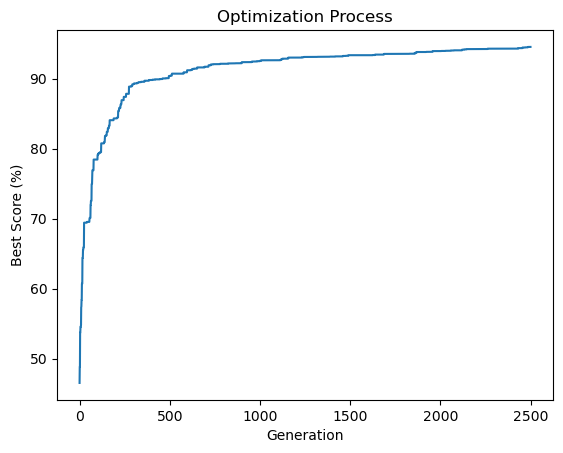

In [8]:
optimal_mask, best_scores = genetic_algorithm()

# Display training proccess
helpers.plot_scores(best_scores,train_size)

# Save the real component as a csv file
np.savetxt("optimal/opt_mask_real.csv", optimal_mask.real, delimiter=",")
# Save the imaginary component as a csv file
np.savetxt("optimal/opt_mask_imag.csv", optimal_mask.imag, delimiter=",")

## Testing 
Testing in optimization refers to the process of evaluating the performance of a trained model on a separate test dataset, which is distinct from the training dataset.
This involves using the optimized model parameters to make predictions on the test dataset and comparing them to the actual values.
The goal of testing in optimization is to determine how well the trained model generalizes to new, unseen data and to identify any issues with overfitting or underfitting.

In [9]:
# Load the complex numpy array from CSV file
opt_mask_real = np.genfromtxt("optimal/opt_mask_real.csv", delimiter=",")
opt_mask_imag = np.genfromtxt("optimal/opt_mask_imag.csv", delimiter=",")

# Combine the real and imaginary components into a complex array
optimal_mask = opt_mask_real + 1j * opt_mask_imag
# Start measure time
start = time.time()
# Calculate score to test dataset
test_score = fitness(test_dataset, optimal_mask, test_labels, test_size)
# End measure time
end = time.time()
# Calculate success percentage 
success_percentage = round((test_score * 100 / test_size),2)

# Calculate time to classify test dataset
elapsed_time = end - start
# Calculate average time to classify a signal image
avg_time = round((elapsed_time / test_size),4)
# Print results
print(f'Success Percentage: {success_percentage} \nAverage time per image: {avg_time} seconds')

Success Percentage: 96.4 
Average time per image: 0.0001 seconds


## Conclusion

In the optical classic course project, we designed an optical system that takes an image of a digit from the MNIST dataset as input and uses an optimization algorithm to find a mask so that the output in the far field will identify which digit it is. We used the genetic algorithm to optimize the mask, and we evaluated the performance of the system using various metrics, such as the accuracy and the mean squared error.

To visualize the performance of the system, we created a display_example function that plots the original image, the optimal mask, and the resulting output image. Our results demonstrated that the optimized optical system was able to accurately identify digits from the MNIST dataset. Overall, this project provided a practical demonstration of the application of optimization algorithms in optical system design.


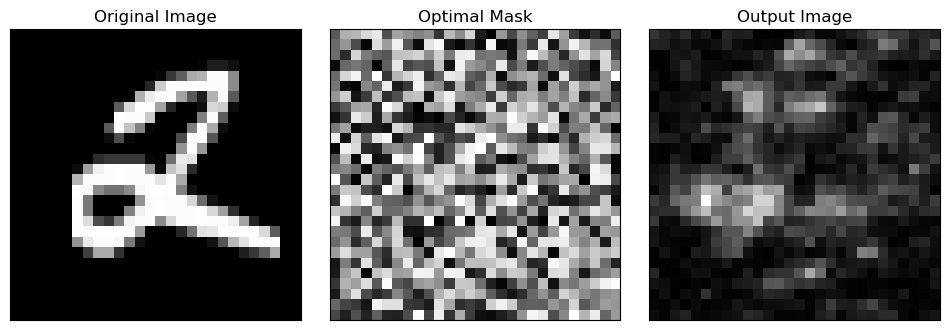

Predicted digit: 2


In [10]:
# Choose random image from test dataset
i = np.random.randint(test_size)
# Reshape image 
image = test_dataset[i].reshape((N,N))
# Modulate image phase 
img_phase = helpers.phase_modulation(image)
# Calculate intesity image
intensity = fresnel_diffraction(img_phase, optimal_mask)
# Show original image, optimal phase and outputh
helpers.display_example(image, optimal_mask, intensity)